# Experiments with Multi Scale Entropy for Unsupervised Classification

References:

1. https://iopscience.iop.org/article/10.3847/0004-637X/820/1/67

2. https://iopscience.iop.org/article/10.1088/0004-637X/754/1/19
3. https://iopscience.iop.org/article/10.1088/0004-637X/753/1/22
4. https://arxiv.org/abs/2009.10862v5

## Imports

In [467]:
import pickle
import george
import scipy
import sncosmo
import astropy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.constants as c

from pyentrp import entropy as ent
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
from astropy.io import ascii
from matplotlib.ticker import LinearLocator
from matplotlib import cm

In [468]:
lc_optical = pd.read_table('2011fe_LC.ascii', sep='\t', comment='#')

# Replaces dumb names
lc_optical.rename(columns={'JD^a': 'JD'}, inplace=True)
lc_optical.rename(columns={'Phase^b': 'Phase'}, inplace=True)
lc_optical.rename(columns={'U (mag)^c': 'U_mag'}, inplace=True)
lc_optical.rename(columns={'B (mag)': 'B_mag'}, inplace=True)
lc_optical.rename(columns={'V (mag)': 'V_mag'}, inplace=True)
lc_optical.rename(columns={'R (mag)': 'R_mag'}, inplace=True)
lc_optical.rename(columns={'I (mag)': 'I_mag'}, inplace=True)
lc_optical.drop(columns='Unnamed: 8', inplace=True)

lc_optical

,JD,Phase,U_mag,B_mag,V_mag,R_mag,I_mag,Telescope
0,5798.17,-16.31,15.013(086),15.185(030),14.797(021),14.740(020),14.848(030),KAIT
1,5798.53,-15.95,14.534(014),14.743(013),14.325(019),14.260(024),14.248(052),LJT
2,5799.16,-15.32,13.894(044),14.027(030),13.685(020),13.641(020),13.745(030),KAIT
3,5799.53,-14.95,13.572(036),13.687(019),13.410(020),13.367(025),13.333(040),LJT
4,5800.17,-14.31,13.138(084),13.225(030),12.943(020),12.921(020),12.991(030),KAIT
...,...,...,...,...,...,...,...,...
114,6090.72,276.24,cdots,16.588(034),16.673(033),17.399(077),16.709(088),TNT
115,6108.53,294.05,cdots,17.318(139),17.234(082),17.850(117),16.937(061),TNT
116,6137.54,323.06,cdots,17.651(101),17.430(071),18.258(090),17.145(059),TNT
117,6160.59,346.11,cdots,17.918(140),17.814(107),18.051(155),18.096(260),TNT


In [469]:
lc_ir = pd.read_table('IR.txt', sep='\t', comment='#')

# Replaces dumb names
lc_ir['JD'] = lc_ir['MJD'] - 50000.5
lc_ir.rename(columns={'J': 'J_mag'}, inplace=True)
lc_ir.rename(columns={'H': 'H_mag'}, inplace=True)
lc_ir.rename(columns={'K_s': 'K_mag'}, inplace=True)
lc_ir.drop(columns=['MJD','Unnamed: 4'], inplace=True)

lc_ir

,J_mag,H_mag,K_mag,JD
0,12.860 (010),12.822 (009),12.855 (031),5799.621
1,11.901 (010),11.898 (008),11.967 (029),5801.668
2,11.566 (011),11.587 (008),11.609 (012),5802.621
3,...,11.317 (010),...,5803.695
4,...,11.124 (008),...,5804.699
5,10.685 (013),10.849 (008),10.809 (014),5806.648
6,10.583 (010),10.768 (008),10.720 (011),5807.602
7,10.503 (009),10.804 (008),10.641 (013),5812.613
8,10.968 (009),11.028 (008),10.890 (012),5818.633
9,11.072 (009),11.036 (008),10.912 (011),5819.590


In [470]:
lc_uv = ascii.read('swift.txt').to_pandas()
lc_uv = lc_uv[np.isnan(lc_uv['mag'])==False]

# Replaces dumb names
lc_uv['JD'] = lc_uv['MJD'] - 50000.5
lc_uv.drop(columns=['Upper','CRate','e_CRate','Flux','e_Flux'], inplace=True)
lc_uv.rename(columns={'Filter': 'Band'}, inplace=True)
lc_uv.rename(columns={'e_mag': 'mag_err'}, inplace=True)
lc_uv.drop(columns='MJD', inplace=True)
lc_uv['Band'] = [a.upper() for a in lc_uv['Band']]

lc_uv = lc_uv[lc_uv['mag'] > 5]

lc_uv

,Band,mag,mag_err,JD
2,UVW2,17.53,0.16,5798.5045
3,UVW2,17.59,0.15,5798.6339
4,UVW2,17.46,0.14,5798.7115
5,UVW2,17.42,0.14,5798.9016
6,UVW2,17.29,0.12,5799.0407
...,...,...,...,...
1027,V,13.45,0.04,5901.0399
1028,V,13.50,0.04,5903.2387
1029,V,13.53,0.04,5904.5753
1030,V,13.61,0.04,5909.4551


In [471]:
optical_bands = ['U', 'B', 'V', 'R', 'I']
ir_bands = ['J', 'H', 'K']
uv_band = [a.upper() for a in np.unique(lc_uv['Band'])]
bands = list(set(optical_bands + ir_bands + uv_band))
bands

['B', 'K', 'H', 'J', 'UVW1', 'I', 'U', 'R', 'V', 'UVM2', 'UVW2']

In [472]:
# In A
wavelengths = {
    'U': 3663,
    'B': 4361,
    'V': 5448,
    'R': 6407,
    'I': 7980,
    'Z': 8680,
    'J': 12200,
    'H': 16300,
    'K': 21900,
    'UVM2': 2310,
    'UVW1': 2910,
    'UVW2': 2120,
    
}

colors = {
    'U': 'purple',
    'B': 'blue',
    'V': 'green',
    'R': 'red',
    'I': 'pink',
    'Z': 'yellow',
    'J': 'orange',
    'H': 'black',
    'K': 'gray',
    'UVM2': 'cyan',
    'UVW1': 'brown',
    'UVW2': 'violet',
}

offsets = {
    'UVM2': -12,
    'UVW1': -8.5,
    'UVW2': -13,
    'U': -3.5,
    'B': 0,
    'V': 2,
    'R': 3.5,
    'I': 5,
    'Z': 5.8,
    'J': 6.5,
    'H': 9,
    'K': 10,
}

In [473]:
formated_lc = []

# OPTICAL LIGHT CURVE
for i in range(len(lc_optical)):
    row = lc_optical.iloc[i]
    JD, telescope = row['JD'], row['Telescope']
    for band in optical_bands:
        
        m = row[f'{band}_mag']
        m_split = m.split('(')
        
        # Make sure there is some real value
        if m_split != ['cdots']:
            
            mag, mag_err = m_split
            mag = float(mag)
            mag_err = float("0."+mag_err[:-1])
            effective_wavelength = wavelengths[band]
            
            d = {
                'JD': JD,
                'Band': band,
                'mag': mag,
                'mag_err': mag_err,
                'effective_wavelength': effective_wavelength,
            }
            
            temp_df = pd.DataFrame([d])
            formated_lc.append(temp_df)

# IR LIGHT CURVE
for i in range(len(lc_ir)):
    row = lc_ir.iloc[i]
    JD = row['JD']
    for band in ir_bands:
        
        m = row[f'{band}_mag']
        m_split = m.split(' (')
        
        # Make sure there is some real value
        if m_split != [' ... ']:
            
            mag, mag_err = m_split
            mag = float(mag)
            mag_err = float("0."+mag_err[:-1])
            effective_wavelength = wavelengths[band]
            
            d = {
                'JD': JD,
                'Band': band,
                'mag': mag,
                'mag_err': mag_err,
                'effective_wavelength': effective_wavelength,
            }
            
            temp_df = pd.DataFrame([d])
            formated_lc.append(temp_df)

# UV LIGHT CURVE
lc_uv['effective_wavelength'] = [wavelengths[a] for a in lc_uv['Band']]
formated_lc.append(lc_uv)
            
formated_lc = pd.concat(formated_lc, ignore_index=True)
formated_lc.sort_values('JD', inplace=True)

# Code to remove the last three observations which cause uncertainties to blow up
#formated_lc = formated_lc.iloc[:-3]

formated_lc.to_csv('2011fe_formatted_lc.csv')
formated_lc

,JD,Band,mag,mag_err,effective_wavelength
1143,5797.4237,UVW1,17.490,0.140,2910
1328,5797.4252,U,15.780,0.070,3663
1480,5797.4261,B,15.660,0.060,4361
1558,5797.4309,V,15.270,0.060,5448
1144,5797.4906,UVW1,17.230,0.130,2910
...,...,...,...,...,...
553,6160.5900,R,18.051,0.155,6407
554,6160.5900,I,18.096,0.260,7980
555,6277.5600,V,19.360,0.040,5448
557,6277.5600,I,18.930,0.030,7980


Add sepctra from z band

In [474]:
real_sed = pd.read_csv('sn2011fe.sed')
real_sed['JD'] = real_sed['phase'] + 5814.48

real_sed_grid = np.zeros([len(np.unique(real_sed['JD'])),len(np.unique(real_sed['wave']))])


for i, t in enumerate(np.unique(real_sed['JD'])):
    real_sed_t = real_sed[real_sed['JD']==t].sort_values(by=['wave'])      
    
    real_sed_grid[i, :] = real_sed_t['flux']
    
    #plt.plot(real_sed_t['wave'], real_sed_t['flux'])
    #plt.show()
    
    #print(real_sed_t['wave'], t)
    
k = sncosmo.TimeSeriesSource(wave=np.unique(real_sed['wave']), flux=real_sed_grid, phase=np.unique(real_sed['JD']))
z_band = k.bandmag(band='lsstz', phase=np.unique(real_sed['JD']), magsys="ab")
z_band_time = np.unique(real_sed['JD'])

In [475]:
dspec = {
    'JD': z_band_time,
    'Band': np.array(['Z']*len(z_band)),
    'mag': z_band, 
    'mag_err': np.array([0]*len(z_band)),
    'effective_wavelength': [wavelengths['Z']]*len(z_band),
}
dspec = pd.DataFrame(dspec)
formated_lc = pd.concat([formated_lc, dspec])
bands.append('Z')

In [476]:
d = {
    'JD': np.array([56049.50, 56257.50, 56332.50]) - 50000.5,
    'Band': np.array(['J', 'J', 'J']),
    'mag': np.array([17.18, 17.42, 18.23])+0.91, # Vega to AB
    'mag_err': np.array([0.10, 0.04, 0.18]),
    'effective_wavelength': [wavelengths['J']]*3,
}
d = pd.DataFrame(d)
formated_lc = pd.concat([formated_lc, d])

In [477]:
formated_lc

,JD,Band,mag,mag_err,effective_wavelength
1143,5797.4237,UVW1,17.490000,0.14,2910
1328,5797.4252,U,15.780000,0.07,3663
1480,5797.4261,B,15.660000,0.06,4361
1558,5797.4309,V,15.270000,0.06,5448
1144,5797.4906,UVW1,17.230000,0.13,2910
...,...,...,...,...,...
41,6414.4800,Z,28.084950,0.00,8680
42,6464.4800,Z,29.035945,0.00,8680
0,6049.0000,J,18.090000,0.10,12200
1,6257.0000,J,18.330000,0.04,12200


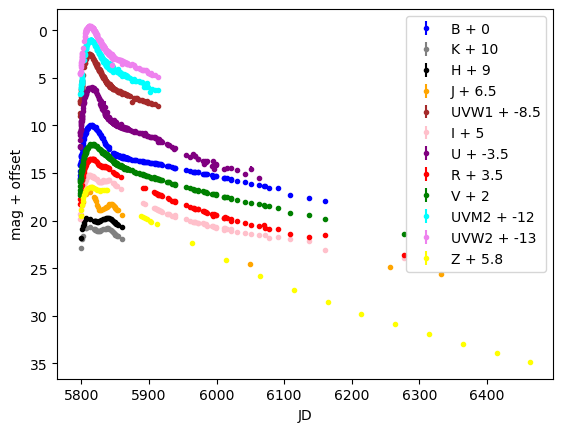

In [478]:
for i, band in enumerate(bands):
    
    offset = offsets[band]
    
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    time = df_pb['JD']
    mag = df_pb['mag']
    mag_err = df_pb['mag_err']
    
    plt.errorbar(time, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)

plt.gca().invert_yaxis()
plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

plt.ion()

## GP with Skelearn

In [479]:
mag = formated_lc['mag'].to_numpy()
mag_err = formated_lc['mag_err'].to_numpy()
jd = formated_lc['JD'].to_numpy()
wavelength = formated_lc['effective_wavelength'].to_numpy()

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(mag)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(mag)

all_times = np.linspace(min(jd), max(jd), 1000)
kernel = 3*Matern(length_scale=[200, 5000], nu=0.2)
#kernel = 0.03*RBF(length_scale=[10, 50000])**2


gp = GaussianProcessRegressor(kernel=kernel, alpha=mag_err**2).fit(np.array([jd, wavelength]).T, mag)

/Users/vedshah/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'mag + offset')

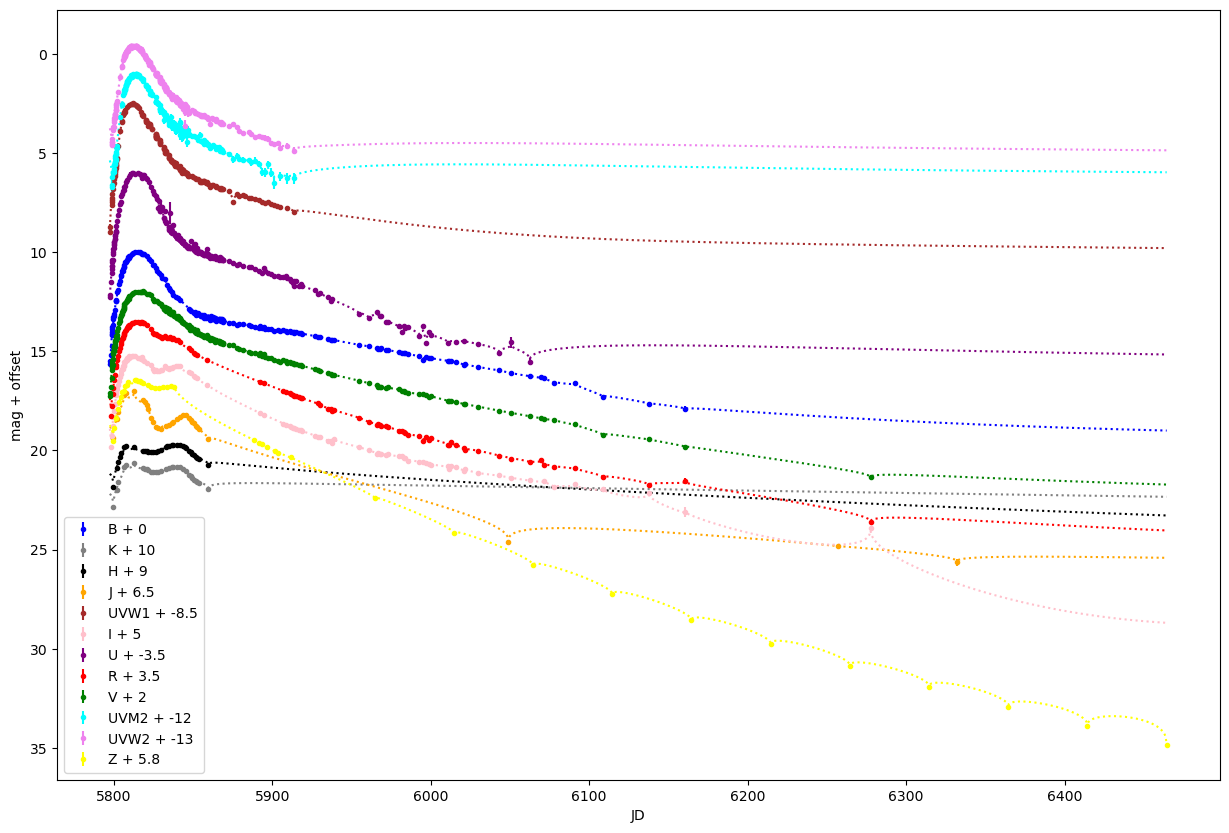

In [480]:
plt.figure(figsize=[15, 10])
for i, band in enumerate(bands):
    
    offset = offsets[band]
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    jd = df_pb['JD'].to_numpy()
    mag = df_pb['mag'].to_numpy()
    mag_err = df_pb['mag_err'].to_numpy()
    
    pred, pred_var = gp.predict(np.array([all_times, [effective_wavelength]*len(all_times)]).T, return_std=True)

    
    plt.errorbar(jd, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(all_times, pred + offset, color=marker_color, linestyle='dotted')
    #plt.fill_between(all_times, y1=pred+pred_var+offset, y2=pred-pred_var+offset, alpha=0.2, color=marker_color)

plt.legend()
plt.gca().invert_yaxis()
plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

In [454]:
gp.kernel_

2.29**2 * Matern(length_scale=[2.24e+04, 1e+05], nu=0.2)

## GP with Skelearn using normalized LC

In [280]:
mean_dict = {}
std_dict = {}

formated_lc['norm_mag'] = np.zeros(len(formated_lc))

for i, band in enumerate(bands):
    
    offset = offsets[band]
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    # Mind the mean and std of the passband
    mean_dict[band] = np.mean(df_pb['mag'])
    std_dict[band] = np.std(df_pb['mag'])
    
    normalized_lc = (df_pb['mag'].to_numpy() - mean_dict[band])/std_dict[band]
    

    formated_lc.loc[formated_lc['Band']==band, ['norm_mag']] = normalized_lc
formated_lc

,JD,Band,mag,mag_err,effective_wavelength,norm_mag
1143,5797.4237,UVW1,17.49,0.14,2910,2.427252
1328,5797.4252,U,15.78,0.07,3663,1.213688
1480,5797.4261,B,15.66,0.06,4361,1.399148
1558,5797.4309,V,15.27,0.06,5448,1.540159
1144,5797.4906,UVW1,17.23,0.13,2910,2.251592
...,...,...,...,...,...,...
557,6277.5600,I,18.93,0.03,7980,2.528569
556,6277.5600,R,20.10,0.06,6407,2.739536
0,6049.0000,J,18.09,0.10,12200,2.851835
1,6257.0000,J,18.33,0.04,12200,2.973056


In [291]:
norm_mag = formated_lc['norm_mag'].to_numpy()
jd = formated_lc['JD'].to_numpy()
wavelength = formated_lc['effective_wavelength'].to_numpy()

all_times = np.linspace(min(jd), max(jd), 1000)

kernel = 50000**2*Matern(length_scale=[400, 1000], nu=0.2)
kernel = 0.0000000003*RBF(length_scale=[10000000, 5000])

gp = GaussianProcessRegressor(kernel=kernel, optimizer=None).fit(np.array([jd, wavelength]).T, norm_mag)

Text(0, 0.5, 'mag + offset')

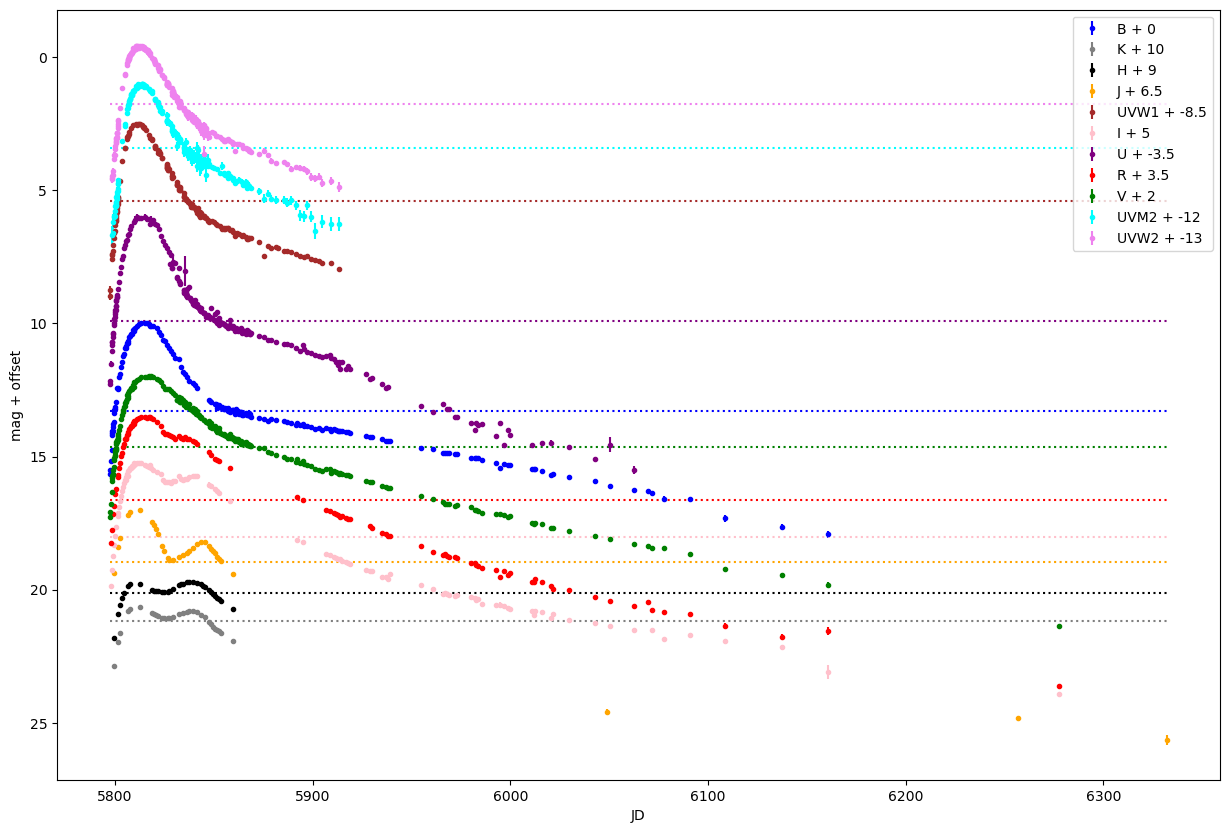

In [292]:
plt.figure(figsize=[15, 10])
for i, band in enumerate(bands):
    
    offset = offsets[band]
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    jd = df_pb['JD'].to_numpy()
    mag = df_pb['mag'].to_numpy()
    mag_err = df_pb['mag_err'].to_numpy()
    
    pred, pred_var = gp.predict(np.array([all_times, [effective_wavelength]*len(all_times)]).T, return_std=True)
    pred = pred * std_dict[band] + mean_dict[band]

    
    plt.errorbar(jd, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(all_times, pred + offset, color=marker_color, linestyle='dotted')
    #plt.fill_between(all_times, y1=pred+pred_var+offset, y2=pred-pred_var+offset, alpha=0.2, color=marker_color)

plt.legend()
plt.gca().invert_yaxis()
plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

## Create the SED

In [336]:
# Create the SED

all_times = np.arange(min(formated_lc['JD']), max(formated_lc['JD']) + 1, 1)
all_wavelengths = np.sort(np.array(list(wavelengths.values())))

x = []
y = []
for t in all_times:
    
    x_temp = np.array([[t]*len(all_wavelengths), all_wavelengths]).T
    pred, pred_var = gp.predict(x_temp, return_std=True)
    
    x.append(x_temp)
    y.append(pred)

# Stack all times and wavelengths 
x = np.vstack(x)
y = np.vstack(y)
#print(x)


print(y)

[[17.05598207 17.48920693 17.24789986 ... 12.22980721 12.15567932
  12.16478647]
 [17.34167842 17.84059841 16.07714622 ... 12.32875062 12.26731175
  12.28389117]
 [16.90284371 17.90336913 15.33953883 ... 12.57126463 12.52625207
  12.55075876]
 ...
 [17.5857352  17.64039241 17.81792112 ... 18.78580978 16.28726533
  14.29629615]
 [17.58121954 17.63573875 17.81270426 ... 18.86601252 16.28650461
  14.29720251]
 [17.57666334 17.6310424  17.80743791 ... 18.88162315 16.28569391
  14.29808749]]


In [337]:
y = np.array(y)
y = np.hstack(y)

In [338]:
sed_mag = pd.DataFrame(x, columns=['Time','Effective Wavelength'])
sed_mag['mag'] = y
sed_mag['flux'] = ((y*u.ABmag).to(u.erg/u.s/u.cm**2/u.Hz) * c.c/(x[:,1]*u.AA)**2).to(u.erg/u.s/u.cm**2/u.AA).value
sed_mag

,Time,Effective Wavelength,mag,flux
0,5797.4237,2120.0,17.055982,3.645492e-15
1,5797.4237,2310.0,17.489207,2.060222e-15
2,5797.4237,2910.0,17.247900,1.621343e-15
3,5797.4237,3663.0,15.669444,4.378941e-15
4,5797.4237,4361.0,15.553286,3.438223e-15
...,...,...,...,...
5891,6332.4237,6407.0,18.713129,8.674800e-17
5892,6332.4237,7980.0,18.603390,6.186698e-17
5893,6332.4237,12200.0,18.881623,2.048575e-17
5894,6332.4237,16300.0,16.285694,1.253626e-16


In [339]:
sed_mag = sed_mag.drop(columns=['mag'])
sed_mag.to_csv("2011fe.csv", index=False)

In [340]:
sed_mag.sort_values(by=['Time', 'Effective Wavelength'])

,Time,Effective Wavelength,flux
0,5797.4237,2120.0,3.645492e-15
1,5797.4237,2310.0,2.060222e-15
2,5797.4237,2910.0,1.621343e-15
3,5797.4237,3663.0,4.378941e-15
4,5797.4237,4361.0,3.438223e-15
...,...,...,...
5891,6332.4237,6407.0,8.674800e-17
5892,6332.4237,7980.0,6.186698e-17
5893,6332.4237,12200.0,2.048575e-17
5894,6332.4237,16300.0,1.253626e-16


In [341]:
flux_grid =np.zeros([len(all_times), len(all_wavelengths)])

for i, t in enumerate(all_times):
    
    flux_grid[i, :] = sed_mag[sed_mag['Time']==t]['flux']
    
flux_grid.shape, all_times.shape, all_wavelengths.shape

((536, 11), (536,), (11,))

In [342]:
sed = sncosmo.TimeSeriesSource(wave=all_wavelengths, flux=flux_grid, phase=all_times)
all_times, sed.bandmag(band='lsstr', phase=all_times, magsys="ab")

(array([5797.4237, 5798.4237, 5799.4237, 5800.4237, 5801.4237, 5802.4237,
        5803.4237, 5804.4237, 5805.4237, 5806.4237, 5807.4237, 5808.4237,
        5809.4237, 5810.4237, 5811.4237, 5812.4237, 5813.4237, 5814.4237,
        5815.4237, 5816.4237, 5817.4237, 5818.4237, 5819.4237, 5820.4237,
        5821.4237, 5822.4237, 5823.4237, 5824.4237, 5825.4237, 5826.4237,
        5827.4237, 5828.4237, 5829.4237, 5830.4237, 5831.4237, 5832.4237,
        5833.4237, 5834.4237, 5835.4237, 5836.4237, 5837.4237, 5838.4237,
        5839.4237, 5840.4237, 5841.4237, 5842.4237, 5843.4237, 5844.4237,
        5845.4237, 5846.4237, 5847.4237, 5848.4237, 5849.4237, 5850.4237,
        5851.4237, 5852.4237, 5853.4237, 5854.4237, 5855.4237, 5856.4237,
        5857.4237, 5858.4237, 5859.4237, 5860.4237, 5861.4237, 5862.4237,
        5863.4237, 5864.4237, 5865.4237, 5866.4237, 5867.4237, 5868.4237,
        5869.4237, 5870.4237, 5871.4237, 5872.4237, 5873.4237, 5874.4237,
        5875.4237, 5876.4237, 5877.423

In [343]:
formated_lc[formated_lc['Band']=='R'].sort_values(by='JD')

,JD,Band,mag,mag_err,effective_wavelength,norm_mag
3,5798.17,R,14.740,0.020,6407,0.630461
8,5798.53,R,14.260,0.024,6407,0.441588
13,5799.16,R,13.641,0.020,6407,0.198022
18,5799.53,R,13.367,0.025,6407,0.090207
23,5800.17,R,12.921,0.020,6407,-0.085287
...,...,...,...,...,...,...
541,6090.72,R,17.399,0.077,6407,1.676735
545,6108.53,R,17.850,0.117,6407,1.854196
549,6137.54,R,18.258,0.090,6407,2.014738
553,6160.59,R,18.051,0.155,6407,1.933287


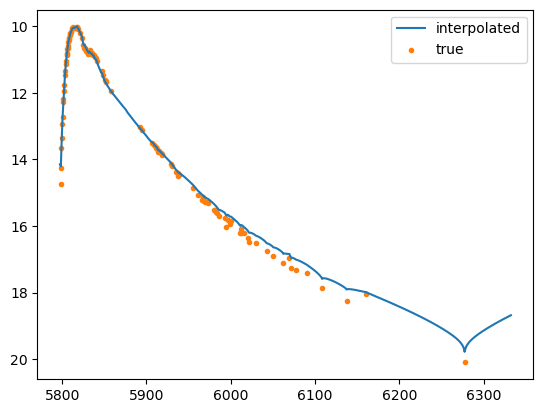

In [348]:
plt.plot(all_times, sed.bandmag(band='lsstr', phase=all_times, magsys="ab"), label='interpolated')
plt.scatter(formated_lc[formated_lc['Band']=='R'].sort_values(by='JD')['JD'], formated_lc[formated_lc['Band']=='R'].sort_values(by='JD')['mag'], label='true', color='C1', marker='.')
plt.legend()
plt.gca().invert_yaxis()

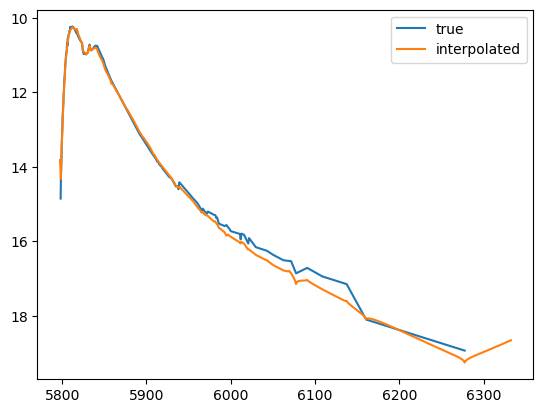

In [345]:
plt.plot(formated_lc[formated_lc['Band']=='I'].sort_values(by='JD')['JD'], formated_lc[formated_lc['Band']=='I'].sort_values(by='JD')['mag'], label='true')
plt.plot(all_times, sed.bandmag(band='lssti', phase=all_times, magsys="ab"), label='interpolated')
plt.legend()
plt.gca().invert_yaxis()

In [346]:
gp.kernel_.length_scale

AttributeError: 'Product' object has no attribute 'length_scale'

In [219]:
gp.kernel_.nu

0.2

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = all_wavelengths
Y = all_times
X, Y = np.meshgrid(X, Y)
Z = flux_grid

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.zaxis.set_scale('log')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Optimize for the amplitude of the factor, and the scalin factors for the time and wavelenth and the mean function.

## With Flux

In [131]:
flux = (formated_lc['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
jd = formated_lc['JD'].to_numpy()
wavelength = formated_lc['effective_wavelength'].to_numpy()

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(flux)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(flux)

all_times = np.arange(min(jd), max(jd), 1)

all_times = np.linspace(min(jd), max(jd), 1000)
kernel = Matern(length_scale=[100, 1000], nu=0.2)

gp = GaussianProcessRegressor(kernel=kernel).fit(np.array([jd, wavelength]).T, flux)

/Users/vedshah/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/vedshah/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Text(0, 0.5, 'mag + offset')

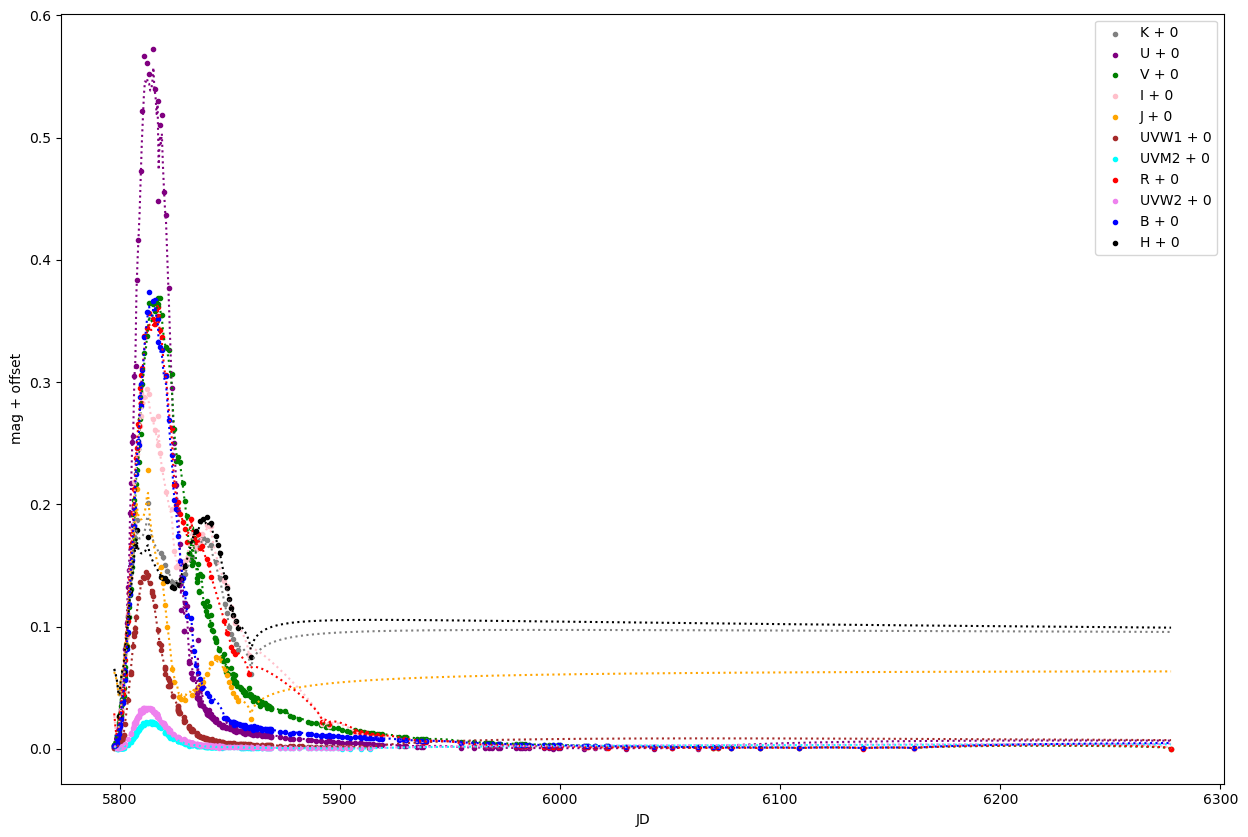

In [153]:
plt.figure(figsize=[15, 10])
lc = {}
for i, band in enumerate(bands):
    
    offset = 0
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    jd = df_pb['JD'].to_numpy()
    flux = (df_pb['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
    
    pred, pred_var = gp.predict(np.array([all_times, [effective_wavelength]*len(all_times)]).T, return_std=True)
    lc[band] = [all_times, (pred * u.Jansky).to(u.ABmag).value]
    
    
    plt.scatter(jd, flux + offset, marker='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(all_times, pred + offset, color=marker_color, linestyle='dotted')
    #plt.fill_between(all_times, y1=pred+pred_var+offset, y2=pred-pred_var+offset, alpha=0.2, color=marker_color)

plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

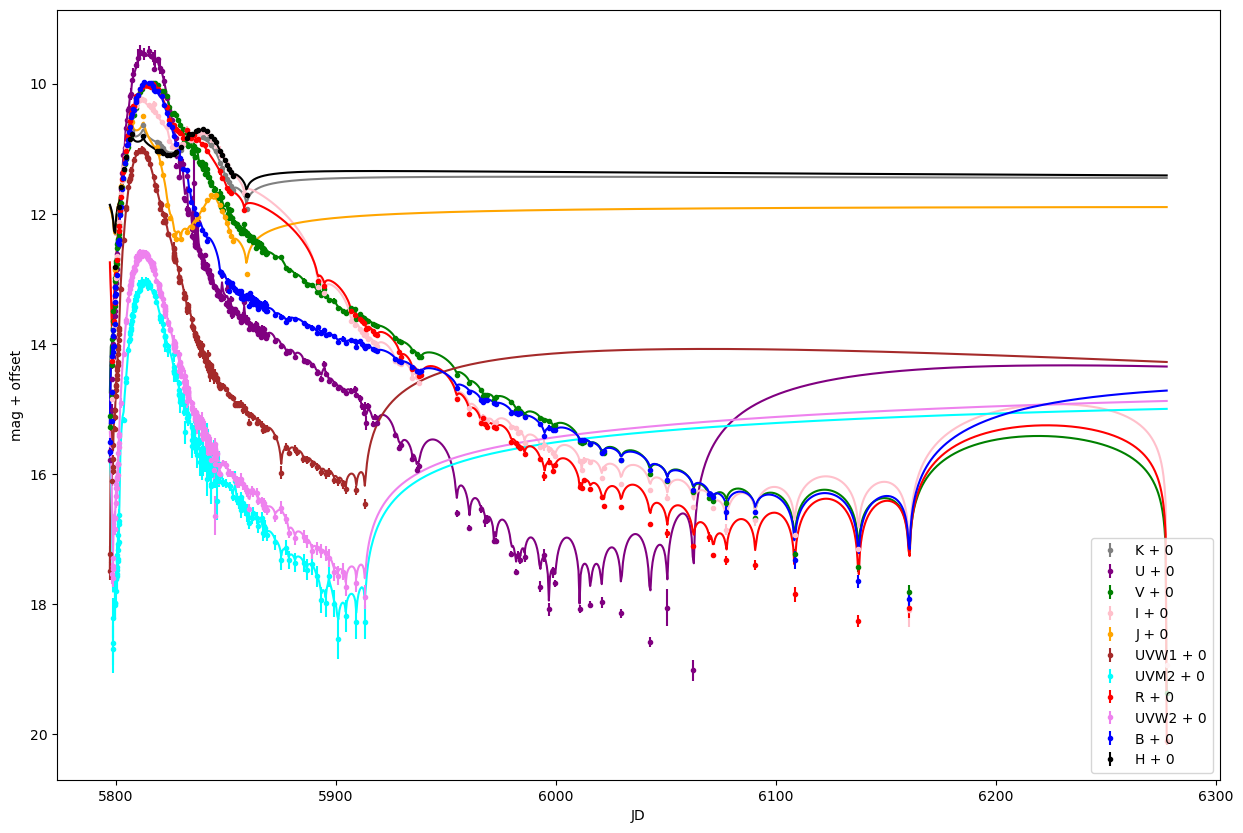

In [154]:
plt.figure(figsize=[15, 10])
for i, band in enumerate(bands):
    
    offset = 0
    
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    time = df_pb['JD']
    mag = df_pb['mag']
    mag_err = df_pb['mag_err']
    t, m = lc[band]
    
    plt.errorbar(time, mag + offset, yerr=mag_err, fmt='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(t, m,  color=marker_color)

plt.gca().invert_yaxis()
plt.legend()

plt.xlabel('JD')
plt.ylabel('mag + offset')

plt.ion()

In [163]:
idx_b_max = np.argmin(formated_lc[formated_lc['Band']=='B']['mag'].to_numpy())
formated_lc[formated_lc['Band']=='B']['JD'].to_numpy()[idx_b_max]

5813.14

## With George

In [110]:
flux = (formated_lc['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
flux_err = (formated_lc['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
jd = formated_lc['JD'].to_numpy()
wavelength = formated_lc['effective_wavelength'].to_numpy()

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(flux)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(flux)

all_times = np.arange(min(jd), max(jd), 1)

signal_to_noises = np.abs(flux) / np.sqrt(
    flux_err ** 2 + (1e-2 * np.max(flux)) ** 2
)
scale = np.abs(flux[signal_to_noises.argmax()])

kernel = (1000)**2 * george.kernels.Matern32Kernel(
    [10**3, 1000**2], ndim=2
)

gp = george.GP(kernel, mean=1)
gp.compute(np.array([jd, wavelength]).T, flux_err)

# result = scipy.optimize.minimize(neg_ln_like,
#                                  gp.get_parameter_vector(),
#                                  jac=grad_neg_ln_like)
# gp.set_parameter_vector(result.x)
# print(result.x)

Text(0, 0.5, 'mag + offset')

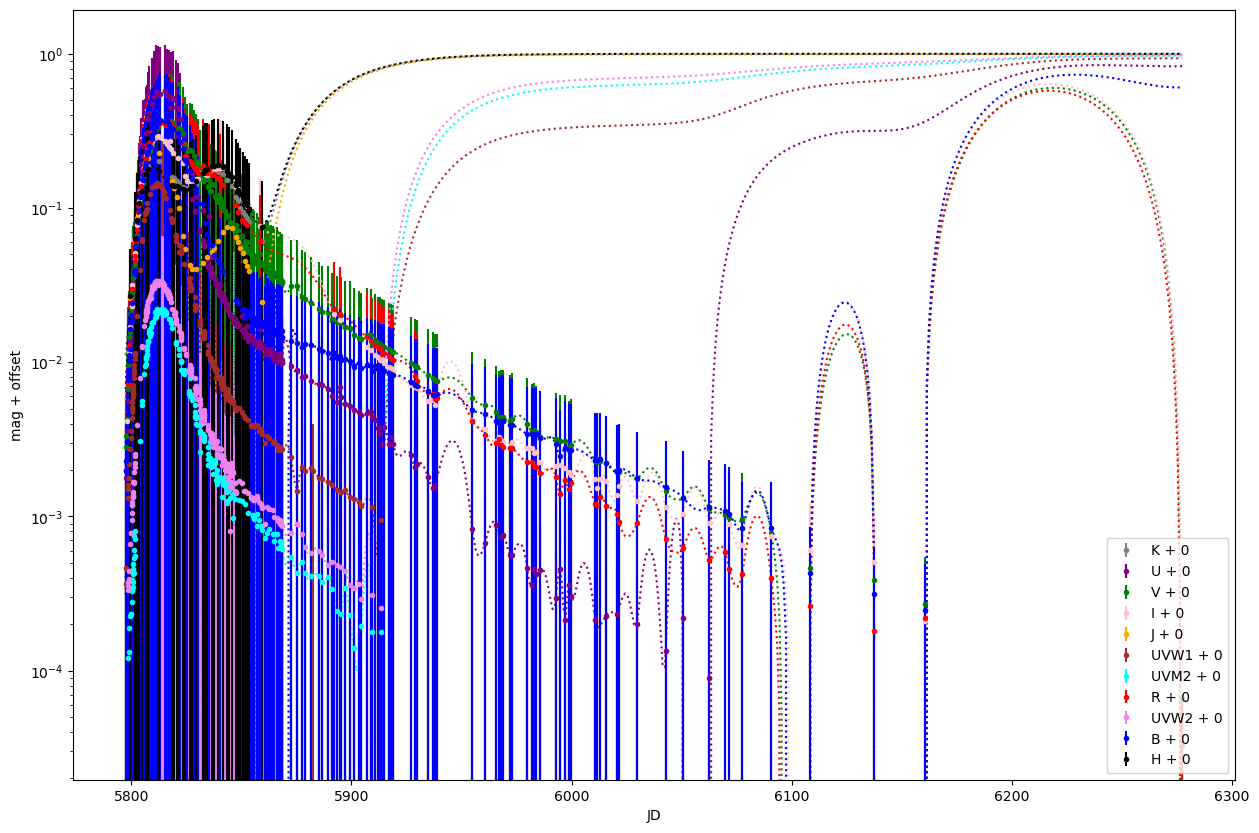

In [111]:
plt.figure(figsize=[15, 10])
for i, band in enumerate(bands):
    
    offset = 0
    
    effective_wavelength = wavelengths[band]
    df_pb = formated_lc[formated_lc['Band']==band]
    
    marker_color = colors[band]
    jd = df_pb['JD'].to_numpy()
    flux = (df_pb['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
    flux_err = (df_pb['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
    
    all_flux = (formated_lc['mag'].to_numpy() * u.ABmag).to(u.Jansky).value
    
    pred, pred_var = gp.predict(all_flux, np.array([all_times, [effective_wavelength]*len(all_times)]).T, return_var=True)
    pred_std = pred_var**0.5

    
    plt.errorbar(jd, flux + offset, yerr=flux_err, fmt='.', label=f"{band} + {offset}", color=marker_color)
    plt.plot(all_times, pred + offset, color=marker_color, linestyle='dotted')
    #plt.fill_between(all_times, y1=pred+pred_std+offset, y2=pred-pred_std+offset, alpha=0.2, color=marker_color)
    #plt.fill_between(all_times, y1=pred+2*pred_std+offset, y2=pred-2*pred_std+offset, alpha=0.2, color=marker_color)

plt.legend()
#plt.gca().invert_yaxis()
plt.legend()

#plt.xlim(5780, 6170)

plt.yscale('log')

plt.xlabel('JD')
plt.ylabel('mag + offset')

In [484]:
df.loc[(df['Band']==__) & (df['Effective Wavelength']==2120.0)]

,Time,Effective Wavelength,flux
